In [10]:
import pickle
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import random
import numpy as np
from time import time
import csv
%matplotlib inline
import math
import Queue

In [34]:
INTERSECTION = 0
BRIDGE = 1
MI_PER_DEGREE_LAT = 69.4
MI_PER_DEGREE_LONG = math.cos(math.radians(37.75)) * MI_PER_DEGREE_LAT

In [12]:
# Load road network
H = nx.read_gpickle("quick_traffic_model/input/graphMTC_CentroidsLength3int_nx2.gpickle")
G = nx.Graph()
G.add_nodes_from(H.nodes(data=True))
G.add_edges_from(H.edges(data=True))

# Make intersections node type 0 to separate from bridges
for n in G.nodes():
    G.nodes[n]['nodetype'] = INTERSECTION # intersection, not bridge

print 'finished loading road network'
G = G.to_undirected()

# Open bridge database
bridges_dict = None
with open('quick_traffic_model/input/20140114_master_bridge_dict.pkl','rb') as f:
    bridges_dict = pickle.load(f)

# Add list of bridges on each road segment
for b_num in bridges_dict.keys():
    bridge_edges = bridges_dict[b_num]['a_b_pairs_direct']
    new_id = str(bridges_dict[b_num]['new_id'])
    #if len(bridge_edges) == 0:
    #    print bridges_dict[b_num]
    for [u,v] in bridge_edges:
        G.edges[str(u),str(v)]['bridges'].append('b' + new_id)
        
intersections_G = G.copy()

# For each bridge, make a new node connecting to the proper intersections
for (u,v) in intersections_G.edges():
    if len(intersections_G.edges[u,v]['bridges']) > 0:
        bridge_list = G.edges[u,v]['bridges']
        uvt_0 = G.edges[u,v]['t_0']
        uvdistance = G.edges[u,v]['distance']
        for bridge in bridge_list:
            if not G.has_node(bridge):
                G.add_node(bridge, nodetype=BRIDGE)
            G.add_edge(u, bridge, t_0 = uvt_0/2, distance = uvdistance/2)
            G.add_edge(bridge, v, t_0 = uvt_0/2, distance = uvdistance/2)
        G.remove_edge(u,v)

# add in bridge locations
with open('quick_traffic_model/bridge_metadata_NBI.csv') as bridges_file:
    reader = csv.reader(bridges_file)
    next(reader)
    while True:
        try:
            next_line = next(reader)
        except StopIteration:
            break
        bid = next_line[0]
        lat = next_line[8]
        lon = next_line[9]
        if 'b'+bid in G.nodes:
            G.nodes['b'+bid]['pos'] = (float(lat), float(lon))

print 'finished adding bridges'
bridges_and_intersections_G = G.copy()

finished loading road network
finished adding bridges


In [ ]:
# MAKE THE BRIDGE NETWORK
# Remove the intersections
MAX_EDGES_BETWEEN = 30
MAX_TIME_BETWEEN = 10*60
MAX_DISTANCE_BETWEEN = 10
MAX_L2_DIST_BETWEEN = 10
for n1, n2 in bridges_and_intersections_G.edges():
    G.edges[n1, n2]['edges_between'] = 1

for n in list(G.nodes()):
    if G.nodes[n]['nodetype'] == INTERSECTION:
        ns = list(G.neighbors(n))
        for v1 in range(len(ns)):
            for v2 in range(v1+1, len(ns)):
                v1n = ns[v1]
                v2n = ns[v2]
                new_edge_dist = (G.edges[n,v1n]['edges_between'] + 
                                 G.edges[n,v2n]['edges_between'])
                new_time_dist = (G.edges[n,v1n]['t_0'] + 
                                 G.edges[n,v2n]['t_0'])
                new_dist = (G.edges[n,v1n]['distance'] + 
                            G.edges[n,v2n]['distance'])
                if G.has_edge(v1n, v2n):
                    new_edge_dist = min(new_edge_dist, G.edges[v1n, v2n]['edges_between'])
                    new_time_dist = min(new_time_dist, G.edges[v1n, v2n]['t_0'])
                    new_dist = min(new_dist, G.edges[v1n, v2n]['distance'])
                l2_dist = 0
                if G.nodes[v1n]['nodetype'] == BRIDGE and G.nodes[v2n]['nodetype'] == BRIDGE:
                    lat1,lon1 = G.node[v1n]['pos']
                    lat2,lon2 = G.node[v2n]['pos']
                    l2_dist = np.sqrt((MI_PER_DEGREE_LAT**2 * (lat1 - lat2)**2) + (MI_PER_DEGREE_LONG**2 * (lon1 - lon2)**2))
                if (new_edge_dist <= MAX_EDGES_BETWEEN and 
                    new_time_dist <= MAX_TIME_BETWEEN and
                    new_dist <= MAX_DISTANCE_BETWEEN and
                    l2_dist <= MAX_L2_DIST_BETWEEN):
                    G.add_edge(v1n, v2n, 
                               edges_between = new_edge_dist, 
                               t_0 = new_time_dist,
                               distance = new_dist)
        G.remove_node(n)
        

print 'finished removing road intersections'
bridges_G = G.copy()

print 'removing', len(list(bridges_G.selfloop_edges())), 'self-loop edges'
bridges_G.remove_edges_from(bridges_G.selfloop_edges())
print 'removing', len(list(nx.isolates(bridges_G))), 'isolated bridges'
bridges_G.remove_nodes_from(list(nx.isolates(bridges_G)) )

In [ ]:
#print G.nodes()
#print G.edges()
#print 'INTERSECTIONS'
#for (u,v) in intersections_G.edges():
#    if len(intersections_G.get_edge_data(u, v)['bridges']) > 0:
#        print u,v,intersections_G.get_edge_data(u, v)
    
# 7016 6970 {'distance': 2.079999, 'dailyvolume': 133477, 'capacity_0': 9500, 'lanes': 5, 
# 'bridges': ['b956', 'b960', 'b1743'], 't_a': 124, 'flow': 0, 'distance_0': 2.079999, 'capacity': 9500, 't_0': 124}

    
#print 'INTERSECTIONS AND BRIDGES'
#for (u,v) in intersections_G.edges()[:100]:
#    print u,v,bridges_and_intersections_G.get_edge_data(u, v)

In [ ]:
# all on same road segment
#print 'b956', 'b960', bridges_G.get_edge_data('b956', 'b960')
#print 'b1743', 'b960', bridges_G.get_edge_data('b1743', 'b960')
#print 'b956', 'b1743', bridges_G.get_edge_data('b956', 'b1743')

# b959 is adjacent to all 3 if in parallel, not if in series
#print 'b959', 'b956', bridges_G.get_edge_data('b956', 'b960')
#print 'b959', 'b960', bridges_G.get_edge_data('b1743', 'b960')
#print 'b959', 'b1743', bridges_G.get_edge_data('b956', 'b1743')

# confirm that gives different results than missing edges
#print 'fake', 'fake2', bridges_G.get_edge_data('fake', 'fake2')

In [ ]:
#compare_community_metrics(bridges_G)

In [51]:
def compare_community_metrics(graph, num_iters=10, num_retrofits=5):
    modularity = np.zeros(num_iters)
    performance = np.zeros(num_iters)
    coverage = np.zeros(num_iters)
    
    for i in range(num_iters):
        retrofitted = random.sample(graph.nodes(), num_retrofits)
        not_retrofitted = [n for n in graph.nodes() if n not in retrofitted]
        modularity[i] = community.modularity(graph, [retrofitted, not_retrofitted])
        performance[i] = community.performance(graph, [retrofitted, not_retrofitted])
        coverage[i] = community.coverage(graph, [retrofitted, not_retrofitted])
        print(modularity[i], performance[i], coverage[i])
    
    print('modularity:', np.argsort(modularity)) 
    print('performance:', np.argsort(performance))
    print('coverage:', np.argsort(coverage))

def get_highest_coverage(graph, num_tries=100, num_retrofits=5, num_samples=10, max_kl_iter=5):
    # run num_tries simulations of retrofitting num_retrofits bridges, and pick the best num_samples
    retrofit_sets = []
    coverages = np.zeros(num_tries)
    
    for i in range(num_tries):
        # pick num_retrofits nodes to be retrofitted
        retrofitted = random.sample(graph.nodes(), num_retrofits)
        not_retrofitted = [n for n in graph.nodes() if n not in retrofitted]
        #new_part = [retrofitted, not_retrofitted]
        new_part = community.kernighan_lin_bisection(graph, partition=[retrofitted, not_retrofitted], max_iter=max_kl_iter)
        coverages[i] = community.coverage(graph, new_part)
        retrofit_sets.append(list(new_part[0]))
        print 'done with iteration', i
    
    argsorted = np.argsort(coverages)
    selection = [retrofit_sets[i] for i in argsorted[:num_samples]]
    return selection

In [7]:
tic = time()
retrofit_samples = get_highest_coverage(bridges_G, num_tries=10, num_retrofits=50, num_samples=10)
print(time() - tic)
print retrofit_samples

0.9998483393155048
0
0.9998988928770032
1
0.9998988928770032
2
0.9998988928770032
3
0.999873616096254
4
0.9998483393155048
5
0.9997219554117588
6
0.9997725089732572
7
0.9998483393155048
8
0.9997725089732572
9
291.801387072
[['b1570', 'b1575', 'b1576', 'b1435', 'b541', 'b1436', 'b1534', 'b1473', 'b1472', 'b1476', 'b1467', 'b584', 'b1482', 'b1649', 'b1219', 'b1644', 'b1144', 'b1146', 'b1536', 'b1428', 'b1516', 'b1663', 'b1738', 'b1221', 'b639', 'b1137', 'b1456', 'b1596', 'b1695', 'b1515', 'b1690', 'b1510', 'b1418', 'b1556', 'b1555', 'b1561', 'b1661', 'b1628', 'b1441', 'b1446', 'b1413', 'b550', 'b634', 'b1405', 'b512', 'b1386', 'b1650', 'b1653', 'b1654', 'b843'], ['b1570', 'b1575', 'b1576', 'b1435', 'b1738', 'b786', 'b1405', 'b1534', 'b225', 'b584', 'b1482', 'b1473', 'b1219', 'b1144', 'b1146', 'b1644', 'b1467', 'b1428', 'b1695', 'b1649', 'b541', 'b1221', 'b639', 'b1436', 'b634', 'b1456', 'b1516', 'b1515', 'b1690', 'b1510', 'b1556', 'b1536', 'b1555', 'b1596', 'b1418', 'b1446', 'b1661', 'b1

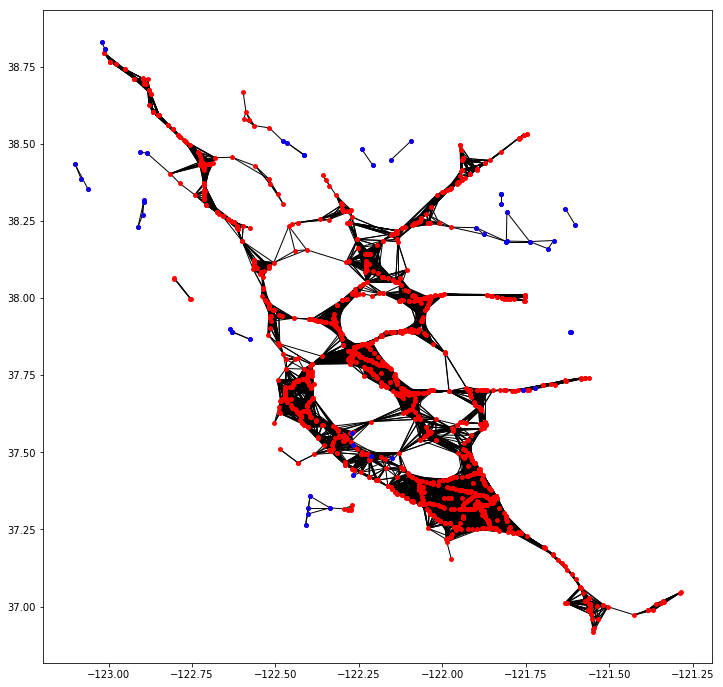

In [13]:
pos=nx.get_node_attributes(bridges_G,'pos') # positions for all nodes

fig = plt.figure(figsize=(12,12))

# nodes
nx.draw_networkx_nodes(bridges_G, pos,
                       node_color='r',
                       node_size=15)
nx.draw_networkx_nodes(bridges_G, pos,
                       nodelist=retrofit_samples[5],
                       node_color='b',
                       node_size=15)

#nx.draw_networkx_labels(bridges_G, pos)

# edges
nx.draw_networkx_edges(bridges_G, pos)

plt.show()

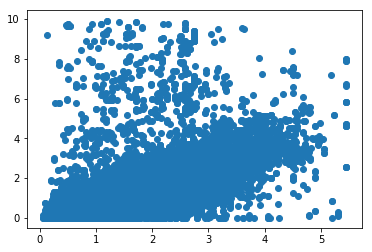

In [11]:


rdists = []
ldists = []

for v1,v2 in bridges_G.edges:
    lat1,lon1 = bridges_G.node[v1]['pos']
    lat2,lon2 = bridges_G.node[v2]['pos']
    ldist = np.sqrt((MI_PER_DEGREE_LAT**2 * (lat1 - lat2)**2) + (MI_PER_DEGREE_LONG**2 * (lon1 - lon2)**2))
    if ldist < 10:
        ldists.append(ldist)
        rdists.append(bridges_G.edges[v1,v2]['distance'])
        #print 'L2 distance:', dist, ', road distance:', bridges_G.edges[v1,v2]['distance']

plt.scatter(rdists, ldists)

In [35]:
def l2_dist(graph, n1, n2):
    lat1,lon1 = graph.node[n1]['pos']
    lat2,lon2 = graph.node[n2]['pos']
    return np.sqrt(((MI_PER_DEGREE_LAT * (lat1 - lat2))**2) + ((MI_PER_DEGREE_LONG * (lon1 - lon2))**2))

In [36]:
# UNIFORM COST SEARCH ALGORITHM adapted from http://cyluun.github.io/blog/uninformed-search-algorithms-in-python
def get_bridges_ucs_graph(bai_G, n, max_d):
    # baiG = bridges_and_intersections_G
    # returns new network of bridges connected to their closest n bridges
    # max_l2_dist limits impossible connections
    closest_neighbors = {}
    
    for start in bai_G.nodes:
        if bai_G.nodes[start]['nodetype'] == BRIDGE:
            #print 'searching for neighbors for', start
            visited = set()
            pqueue = Queue.PriorityQueue()
            pqueue.put((0, start))
            closest_neighbors[start] = []

            while pqueue:
                cost, node = 0, None
                try:
                    cost, node = pqueue.get_nowait()
                except Queue.Empty:
                    break
                if node not in visited:
                    visited.add(node)

                    if bai_G.nodes[node]['nodetype'] == BRIDGE and not node == start:
                        if l2_dist(bai_G, start, node) < max_d:
                            closest_neighbors[start].append(node)
                            if len(closest_neighbors[start]) == n:
                                break
                    else: 
                        for i in bai_G.neighbors(node):
                            if i not in visited:
                                total_cost = cost + bai_G.edges[node,i]['distance']
                                if total_cost < max_d:
                                    pqueue.put((total_cost, i))
    
    G = nx.Graph()
    G.add_nodes_from(bai_G.nodes(data=True))
    
    for node in list(G.nodes):
        if not 'b' in node:
            G.remove_node(node)
    
    for node, new_neighbors in closest_neighbors.items():
        for neighbor in new_neighbors:
            G.add_edge(node, neighbor)
    
    return G

In [54]:
ucs_G = get_bridges_ucs_graph(bridges_and_intersections_G, 5, 20)
print 'removing', len(list(nx.isolates(ucs_G))), 'isolated bridges'
ucs_G.remove_nodes_from(list(nx.isolates(ucs_G)))

removing 6 isolated bridges


In [55]:
tic = time()
retrofit_samples = get_highest_coverage(ucs_G, num_tries=10, num_retrofits=50, num_samples=10, max_kl_iter=2)
print(time() - tic)
print retrofit_samples

done with iteration 0
done with iteration 1
done with iteration 2
done with iteration 3
done with iteration 4
done with iteration 5
done with iteration 6
done with iteration 7
done with iteration 8
done with iteration 9
363.939843178
[['b1570', 'b1576', 'b1247', 'b1260', 'b1435', 'b1436', 'b1471', 'b1536', 'b225', 'b1486', 'b1487', 'b1644', 'b1239', 'b1251', 'b1482', 'b1516', 'b634', 'b1136', 'b1456', 'b1712', 'b1713', 'b1321', 'b1598', 'b1717', 'b1201', 'b1329', 'b1248', 'b1249', 'b1695', 'b1691', 'b1692', 'b1473', 'b1295', 'b1561', 'b1298', 'b94', 'b1669', 'b1661', 'b1663', 'b1336', 'b1337', 'b1443', 'b1446', 'b1338', 'b1520', 'b1525', 'b1441', 'b1653', 'b1654', 'b843'], ['b913', 'b1635', 'b1738', 'b1534', 'b1596', 'b912', 'b914', 'b915', 'b1645', 'b1155', 'b839', 'b1311', 'b1189', 'b1188', 'b332', 'b1169', 'b1183', 'b1185', 'b1184', 'b1649', 'b258', 'b1198', 'b634', 'b909', 'b377', 'b28', 'b1202', 'b1201', 'b1153', 'b885', 'b1190', 'b1191', 'b1556', 'b1197', 'b1195', 'b406', 'b403',

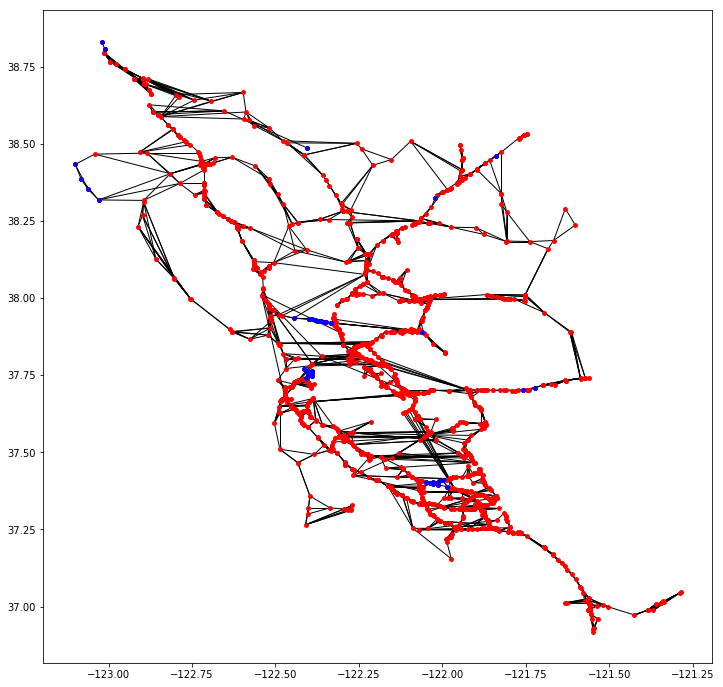

In [59]:
pos=nx.get_node_attributes(ucs_G,'pos') # positions for all nodes

fig = plt.figure(figsize=(12,12))

# nodes
nx.draw_networkx_nodes(ucs_G, pos,
                       node_color='r',
                       node_size=15)
nx.draw_networkx_nodes(ucs_G, pos,
                       nodelist=retrofit_samples[1],
                       node_color='b',
                       node_size=15)

# edges
nx.draw_networkx_edges(ucs_G, pos)

plt.show()

In [60]:
with open('modularity_outputs_50rets.csv', 'w') as modularity_csv:
    writer = csv.writer(modularity_csv)
    for row in retrofit_samples:
        writer.writerow(row)